In [1]:
import psutil
print(psutil.virtual_memory())

svmem(total=8589934592, available=4314628096, percent=49.8, used=2665267200, free=3162488832, active=1157824512, inactive=1102282752, wired=1507442688)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
from transformers import CLIPModel
from transformers import CLIPProcessor
import time
import faiss
import webcolors

In [3]:
filename = "./myntradataset/styles.csv"
df = pd.read_csv(filename, on_bad_lines="skip") #some lines of the dataset fail due to excess commas

available_ids = os.listdir("./myntradataset/images")
available_ids = [int(x.replace(".jpg","")) for x in available_ids]
df = df[df.id.isin(available_ids)] #some images are not actually available
df=df.dropna(subset='productDisplayName')

df.head()


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [4]:
shirts = df.loc[df['articleType'] == 'Jackets']
np.shape(shirts)

(258, 10)

In [5]:
def display_images_and_titles(filepaths, titles):
    # Create a 4x5 grid of subplots
    fig, axes = plt.subplots(4, 5, figsize=(12, 10))

    # Loop through the filepaths and display images in the subplots
    for i, ax in enumerate(axes.flatten()):
        if i < len(filepaths):
            filepath = filepaths[i]
            image = plt.imread(filepath)
            ax.imshow(image)
            ax.axis('off')

            # Assign a title to each subplot
            ax.set_title(f"{titles[i]}", fontsize = 7)
        else:
            ax.axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

def display_images_titles_from_ids(ids, directory):
    df_new_index = df.copy()
    df_new_index['id'] = df_new_index['id'].astype(str)
    df_new_index.set_index("id",inplace = True)
    df_new_index = df_new_index.loc[ids]
    filenames = df_new_index.index.tolist()
    filepaths = [f"{os.path.join(directory,filename)}.jpg"  for filename in filenames]
    titles =  df_new_index.productDisplayName.tolist()
    
    display_images_and_titles(filepaths, titles)

    


In [6]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32") #Import CLIP Model


In [7]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
# You'll need to change this
directory = "/Users/meagankenney/IMA Bootcamp/Ebay/myntradataset/images/"

# Display 20 random images
random_subset = df.iloc[np.random.randint(0,df.shape[0], size = 20)]
filenames = random_subset.id.astype(str).tolist()
filepaths = [f"{os.path.join(directory,filename)}.jpg"  for filename in filenames]
titles = random_subset.productDisplayName.tolist()

display_images_and_titles(filepaths, titles)

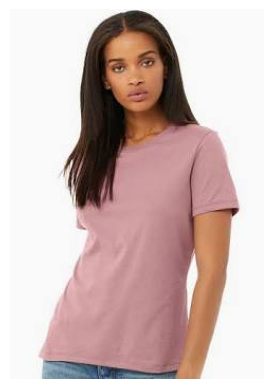

In [11]:
#Open the image
#image = Image.open('/Users/meagankenney/IMA Bootcamp/Ebay/Red_bag.jpeg')
#image = Image.open('/Users/meagankenney/IMA Bootcamp/Ebay/model_Test.png')
image = Image.open('/Users/meagankenney/IMA Bootcamp/Ebay/modelWithShirt.jpeg')

#What text do you want to attach
text=["green shirt"]
newColor = "green"
plt.imshow(image)
plt.axis('off')  # Remove the axis labels
plt.show()

In [12]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [13]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

#whereever you loaded your vit_h file
sam_checkpoint ="/Users/meagankenney/IMA Bootcamp/Ebay/sam_vit_h_4b8939.pth"
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
#sam.to(device=device)

predictor = SamPredictor(sam)

In [14]:
import cv2

def get_clicked_point(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Create a copy of the image for display
    display_image = image.copy()

    # Flag to indicate if a point has been captured
    point_captured = False

    # Variables to store the clicked coordinates
    clicked_x = None
    clicked_y = None

    def click_callback(event, x, y, flags, param):
        nonlocal point_captured, clicked_x, clicked_y

        # Check if the left mouse button is pressed
        if event == cv2.EVENT_LBUTTONDOWN and not point_captured:
            # Store the clicked coordinates
            clicked_x = x
            clicked_y = y

            # Print the coordinates
            print(f"Clicked coordinates: x={clicked_x}, y={clicked_y}")

            # Draw a circle at the clicked point
            cv2.circle(display_image, (clicked_x, clicked_y), 5, (0, 0, 255), -1)
            cv2.imshow("Image", display_image)

            # Set the flag to indicate a point has been captured
            point_captured = True

    # Create a window and set the callback function
    cv2.namedWindow("Image")
    cv2.setMouseCallback("Image", click_callback)

    # Display the image
    cv2.imshow("Image", display_image)

    # Wait for a point to be captured or 'Esc' key is pressed
    while not point_captured:
        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # 'Esc' key
            break

    # Close all windows
    cv2.destroyAllWindows()

    # Return the clicked coordinates if a point was captured, otherwise return None
    if point_captured:
        return [(clicked_x, clicked_y)]
    else:
        return None


In [15]:
#image_path = '/Users/meagankenney/IMA Bootcamp/Ebay/model_Test.png'
#image_path = '/Users/meagankenney/IMA Bootcamp/Ebay/Red_bag.jpeg'
image_path = '/Users/meagankenney/IMA Bootcamp/Ebay/modelWithShirt.jpeg'
#image_path = '/Users/meagankenney/IMA Bootcamp/Ebay/backpackTest.png'
clicked_point = get_clicked_point(image_path)
print("Clicked point:", clicked_point)

Clicked coordinates: x=146, y=161
Clicked point: [(146, 161)]


In [16]:
#put a path to your picture in parentheses below
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [17]:
predictor.set_image(image)

In [18]:
#pick the two numbers in brackets below to indicate on what you want segment anything to create the mask
input_point = np.array(clicked_point)
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

int_mask = masks.astype(int)

In [19]:
# Extracting pixel map:
# Extracting the width and height 
# of the image:
width = image.shape[0]
height = image.shape[1]
for i in range(width):
    for j in range(height):
        # getting the current RGB value of pixel (i,j).
        if int_mask[0][i][j]==0:
            image[i][j]=(255,255,255)
        
        

In [20]:
# Extracting pixel map:
# Extracting the width and height 
# of the image:
colList=[]
width = image.shape[0]
height = image.shape[1]
for i in range(width):
    for j in range(height):
        # getting the current RGB value of pixel (i,j).
        if int_mask[0][i][j]==1:
            colList.append(image[i][j])
        
        

In [21]:
def get_rgb_from_color_name(color_name):
    try:
        rgb = webcolors.name_to_rgb(color_name)
        return tuple(rgb)
    except ValueError:
        return None

In [22]:
def scale_list(values, min_val, max_val):
    # Convert the list to a NumPy array
    arr = np.array(values)

    # Find the minimum and maximum values in the array
    arr_min = np.min(arr)
    arr_max = np.max(arr)

    # Scale the values to be between min_val and max_val
    scaled_arr = (arr - arr_min) * (max_val - min_val) / (arr_max - arr_min) + min_val

    # Convert the scaled array back to a list
    scaled_list = scaled_arr.tolist()

    return scaled_list

In [23]:
def AvgColor(image):  
    colList=[]
    width = image.shape[0]
    height = image.shape[1]
    for i in range(width):
        for j in range(height):
            # getting the current RGB value of pixel (i,j).
            if int_mask[0][i][j]==1:
                colList.append(image[i][j])
    L=len(colList)
    m1=0
    m2=0
    m3=0
    for i in colList:
        m1+=i[0]
        m2+=i[1]
        m3+=i[2]
    return [(m1/L, m2/L, m3/L)]

In [24]:
def colorChange3(col2, pic):
    #Get dimensions of image
    width = pic.shape[0]
    height = pic.shape[1]
    
    #Fix a base color
    startCol = AvgColor(pic)
    
    #How different is this base color from target color?
    dif1 = startCol[0][0] - col2[0]
    dif2 = startCol[0][1] - col2[1]
    dif3 = startCol[0][2] - col2[2]
    
    #Make blank list for new color values
    newColR=[]
    newColG=[]
    newColB=[]
    
    #Make lists of the shifted colors from old to new RGB values
    for i in range(width):
        for j in range(height):
            if int_mask[0][i][j]==1:
                newColR.append(pic[i][j][0]-dif1)
                newColG.append(pic[i][j][1]-dif2)
                newColB.append(pic[i][j][2]-dif3)
                
    #Rescale each color list to make sure it's in appropriate RGB value range
    minR = max(min(newColR), 0)
    maxR = min(max(newColR), 255)
    minG = max(min(newColG), 0)
    maxG = min(max(newColG), 255)
    minB = max(min(newColB), 0)
    maxB = min(max(newColB), 255)
    fixedColR = scale_list(newColR, minR,maxR)
    fixedColG = scale_list(newColG, minG,maxG)
    fixedColB =scale_list(newColB, minB,maxB)
    
    
    #Go through all pixels in the picture and set them to their new color
    n=0
    for i in range(width):
        for j in range(height):
            # Is this picture on the segment we're recoloring?
            if int_mask[0][i][j]==1:
                pic[i][j][0]=fixedColR[n]
                pic[i][j][1]=fixedColG[n]
                pic[i][j][2] = fixedColB[n]
                n+=1
                
    return pic

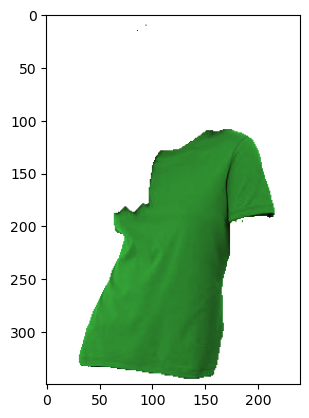

In [25]:
newColorRGB = get_rgb_from_color_name(newColor)

image = colorChange3(newColorRGB, image)

plt.imshow(image)

In [26]:
inputs = processor(text=text, images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)

knn_vectors = torch.load("image_tensor.pt")
knn_labels = df.id.astype(str).tolist()
vectors_np = knn_vectors.numpy()

query_vectors = torch.load("title_tensor.pt")
query_np = query_vectors.numpy()

In [27]:
# Build the index
#dimension = vectors_np.shape[1]  # Dimension of the vectors
dimension = query_np.shape[1] 
index = faiss.IndexFlatL2(dimension)
#index.add(vectors_np)
index.add(query_np)

In [28]:
np_TP = outputs.text_embeds.detach().cpu().numpy()

# Select a query vector
query_vector = np_TP.reshape(1, -1) #This line is different from before

# Query the index
k = 1000  # Number of neighbors to return
D_text, I_text = index.search(query_vector, k)

# `I` now contains the indices of the 10 nearest neighbors to the first vector
# `D` contains the corresponding squared L2 distances

# Get labels of the neighbors
neighbor_labels = [knn_labels[i] for i in I_text[0]]

In [29]:
np_TP = outputs.image_embeds.detach().cpu().numpy()

# Select a query vector
query_vector = np_TP.reshape(1, -1) #This line is different from before

# Query the index
k = 1000  # Number of neighbors to return
D_image, I_image = index.search(query_vector, k)

# `I` now contains the indices of the 10 nearest neighbors to the first vector
# `D` contains the corresponding squared L2 distances

# Get labels of the neighbors
neighbor_labels = [knn_labels[i] for i in I_image[0]]

In [37]:
#Finds the common indexes from the image knn and text knn
common_elements = np.intersect1d(I_image, I_text)

#Makes common elements an array
common_elements_array = common_elements.reshape(1, -1)
#common_elements_array[0]

In [38]:
combo_labels = [knn_labels[i] for i in common_elements_array[0]]

In [44]:
directory = "/Users/meagankenney/IMA Bootcamp/Ebay/myntradataset/images/"
display_images_titles_from_ids(neighbor_labels, directory)